# Bayesian Learning Assignment 1

MSc DSAI Quentin Le Roux

<hr>

## Library Imports

In [1]:
from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets

%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button

import numpy as np
import pandas as pd
from scipy.stats import norm, anderson, beta

## Function declarations

In [2]:
def import_dataset(
    path:      str, 
    index_col: bool = False, 
    header:    int  = 0, 
    sep:       int  = ","
) -> pd.DataFrame:
    """
    Imports a dataset formatted as a .csv file into a Pandas DataFrame.
    """
    data = pd.read_csv(path, index_col=index_col, header=header, sep=sep)
    return data

In [3]:
def norm_testing(data: pd.DataFrame) -> None:
    """
    Tests the null hypothesis that the data follows a normal distribution
    using the Anderson-Darling test
    """
    test = anderson(data)
    result = test[0] <= test[1][4]
    result = "accept" if result else "reject"
    print(f"Given a 99% confidence level, we can {result} the null hypothesis" + \
          " H0 that the data follows a normal distribution (Anderson-Darling normality test).")

In [4]:
def compute_P_with_relative_frequencies(
    data: pd.DataFrame, 
    case: str, 
    condition: str
) -> float:
    """
    Computes a probabilities given the relative frequencies found in 
    a given dataset
    """
    data = data.query(condition)
    occurrences = data.query(case)
    return occurrences["value"].sum()/len(data), data, occurrences

def compute_P_with_norm_distribution(
    data: pd.DataFrame,
    side: str,
    split_point: float
):
    """
    Approximate a probability using a normal distribution with the data
    """
    # Computes the sample mean and standard deviation
    sample_mean = np.mean(data)
    sample_std_dev = np.std(data)
    # Approximates a normal distribution using the sample parameters
    dist = norm(loc = sample_mean, scale=sample_std_dev)
    if side == "left":
        P = dist.cdf(split_point)
    else:
        P = 1 - dist.cdf(split_point)
    return P

In [5]:
def beta_distribution_plot(a:float, b:float) -> None:
    """
    Plots a beta distribution given the alpha and beta parameters
    with both the histograph and its smooth curve
    """
    # Plots the distribution using the code provided by the scipy 
    # library here: 
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html
    data = beta.rvs(a, b, size=1000)
    x = np.linspace(
        beta.ppf(0.01, a, b), 
        beta.ppf(0.99, a, b), 
        100
    )
    fig, ax = plt.subplots(1, 1)
    ax.plot(x, beta.pdf(x, a, b), 'r-', lw=5, alpha=0.6, label='beta pdf')
    ax.hist(data, density=True, histtype="stepfilled", alpha=0.2)
    ax.legend(loc="best", frameon=False)
    plt.show()
    
def beta_distribution_sliderplot(a:float, b:float, n:float, k: float) -> tuple:
    """
    Plots a posterior beta distribution given the alpha and beta parameters of
    the prior and the parameter of the data likelihood n and k seen in exercise 3.
    
    /!\ It is import that the function returns fig, ax, and the slider objects
    otherwise they will be unresponsive outside the function's scope:
    > https://github.com/matplotlib/matplotlib/issues/3105
    """
    a = k+a
    b = n-k+b

    # Creates subplot
    fig, ax = plt.subplots()
    plt.subplots_adjust(bottom=0.35)

    # Creates the x and y axis data for the PDF curve and histogram from a 
    # random sampling of the beta distribution
    x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
    y = beta.rvs(a, b, size=1000)
    z = beta.pdf(x, a, b)
    s = np.quantile(y, [0.05, 0.5, 0.95])
    
    # Computes the statistics: mean, median, variance, 95% confidence interval
    mean = round(beta(a,b).mean(),3)
    median = round(beta(a,b).median(),3)
    variance = round(beta(a,b).var(),3)
    CI = (round(s[0],3), round(s[2],3))
    
    # Plots the starting plot
    ax.plot(x, z, "r-", lw=5, alpha=0.6, label="beta pdf")
    ax.hist(y, density=True, histtype="stepfilled", alpha=0.2)
    ax.axvline(x=beta(a,b).mean(), label="mean")
    ax.legend()
    plt.suptitle(f"Beta Distribution, alpha={round(a,1)}, beta={round(b,1)}\n" + \
                 f"mean={mean}, med={median}, var={variance}, " + \
                 f"CI95%: [{CI[0]}, {CI[1]}]")
    
    # Create axes for alpha and beta sliders
    alp = plt.axes([0.20, 0.15, 0.65, 0.03])
    bet = plt.axes([0.20, 0.1, 0.65, 0.03])
    alpS = Slider(alp, 'alpha', 0., 1000., a)
    betS = Slider(bet, 'beta', 0., 1000., b)

    # Creates a fuction to be called when slider values are changed
    def update(val):
        # retrieves the updated alpha and beta
        a = alpS.val
        b = betS.val
        
        # Creates the x and y axis data for the PDF curve and histogram from a 
        # random sampling of the beta distribution
        x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
        y = beta.rvs(a, b, size=1000)
        z = beta.pdf(x, a, b)
        s = np.quantile(y, [0.05, 0.5, 0.95])
        
        # Computes the statistics: mean, median, variance, 95% confidence interval
        mean = round(beta(a,b).mean(),3)
        median = round(beta(a,b).median(),3)
        variance = round(beta(a,b).var(),3)
        CI = (round(s[0],3), round(s[2],3))
        
        # clears the current plot and replots it
        ax.cla()
        ax.plot(x, z, "r-", lw=5, alpha=0.6, label="beta pdf")
        ax.hist(y, density=True, histtype="stepfilled", alpha=0.2)
        ax.axvline(x=beta(a,b).mean(), label="mean")
        ax.legend()
        plt.suptitle(f"Beta Distribution, alpha={round(a,1)}, beta={round(b,1)}\n" + \
                     f"mean={mean}, med={median}, var={variance}, " + \
                     f"CI95%: [{CI[0]}, {CI[1]}]")

    # Calls the update function when slider values are changed
    alpS.on_changed(update)
    betS.on_changed(update)

    # Displays graph
    plt.show()
    return fig, ax, alpS, betS

In [6]:
def compute_priors_impact_on_posterior_beta_distribution(
    n:float, k: float
) -> pd.DataFrame:
    """
    Computes the impact of a beta distribution prior (by varying its
    alpha and beta parameters) on a posterior beta distribution and stores
    the results (mean, median, 95% confidence interval, etc.) as a 
    Pandas DataFrame.
    """
    # Computes a range of prior parameters and the list of their permutation
    alpha_priors = [1] + list(range(5, 51, 5))
    beta_priors = [1] + list(range(5, 51, 5))
    permutation_pairs = [[ai, bi] for ai in alpha_priors for bi in beta_priors]
    
    # Creates an empty list to store intermediary results
    results = []
    
    # Computes the posterior mean, median, and 95% confidence interval per permutation
    # of prior parameters
    for a, b in permutation_pairs:
        alp = a + k
        bet = b + n - k
        sample = np.random.beta(alp, bet, size = 1000)
        sample_stats = np.quantile(sample, [0.05, 0.5, 0.95])
        results.append([a, b, alp, bet, beta.mean(a=alp, b=bet), beta.median(a=alp, b=bet), 
                        [round(sample_stats[0],3), round(sample_stats[2],3)]])
    
    # Stores the results
    results = pd.DataFrame(
        results, 
        columns = ["alpha", "beta", "post. alpha", "post. beta", "post. mean", "post. median", "95% post. CI"]
    )
    
    # Computes a heatmap of the posterior mean
    heat_postmean = results[["alpha", "beta", "post. mean"]].pivot(
        index ='alpha', columns ='beta'
    )
    heat_postmean = heat_postmean.style.background_gradient(
        cmap ='viridis'
    ).set_properties(
        **{'font-size': '12px'}
    )
    # Computes a heatmap of the posterior median
    heat_postmedian = results[["alpha", "beta", "post. median"]].pivot(
        index ='alpha', columns ='beta'
    )
    heat_postmedian = heat_postmedian.style.background_gradient(
        cmap ='viridis'
    ).set_properties(
        **{'font-size': '12px'}
    )
    return results, heat_postmean, heat_postmedian

## Exercise 1

**Using the football dataset, estimate the following conditional probabilities in two different ways (one through relative frequencies and one using an approximated distribution):**

- P1: Pr(Favorite wins | point spread = 8)
- P2: Pr(Favorite wins by at least 8 points | point spread = 8)
- P3: Pr(Favorite wins by at least 8 points | point spread = 8 and favorite wins)

**ASSUMPTION**: 
> 1. *As with class 3's exercises, we consider tied games as a half-win, i.e. each yields a half-point when counting the number of wins in the dataset.*
>
> 2. *Games with a point spread of 0 are ignored as it indicates that there is no favorite*

In [7]:
# Imports the football dataset

football_dataset_path = 'football_dataset.txt'
football_data = import_dataset(football_dataset_path)

In [8]:
# Removes the entries with a point spread of 0, as it indicates there are no favorite

football_data = football_data[~(football_data["spread"]==0)]

# Computes an outcome column

football_data["outcome"] = football_data["favorite"].sub(football_data["underdog"])

# Keeps the spread and outcome columns only

football_data = football_data[["outcome", "spread"]]

# Creates a value column to count the winnings of the favourite team

scorer = lambda x: 0 if x<0 else 1 if x>0 else 0.5
football_data["value"] = football_data["outcome"].apply(scorer)

### Computing P1

$$P1=\mathbb{P}(Favorite\,\,wins\,\,|\,\,point\,\,spread\,\,=\,\,8)$$

In [9]:
# Computes P1 with relative frequencies

P1, data, _ = compute_P_with_relative_frequencies(
    football_data, "outcome >= 0", "spread == 8"
)
print(f"Computed with relative frequencies, P1: {round(P1, 4)}" + \
      " (rounded to 4 decimals)")

Computed with relative frequencies, P1: 0.7551 (rounded to 4 decimals)


In [10]:
# Tests the gaussian-ness of the data with an Anderson-Darling test

data = data["outcome"]
norm_testing(data)

Given a 99% confidence level, we can accept the null hypothesis H0 that the data follows a normal distribution (Anderson-Darling normality test).


In [11]:
P1 = compute_P_with_norm_distribution(data, "right", 0)
print(f"Computed with an approximated normal distribution, P1: {round(P1, 4)}" + \
      " (rounded to 4 decimals)")

Computed with an approximated normal distribution, P1: 0.7695 (rounded to 4 decimals)


### Computing P2

$$P2=\mathbb{P}(Favorite\,\,wins\,\,by\,\,at\,\,least\,\,8\,\,points\,\,|\,\,point\,\,spread\,\,=\,\,8)$$

In [12]:
# Computes P2 with relative frequencies

P2, data, _ = compute_P_with_relative_frequencies(
    football_data, "outcome >= 8", "spread == 8"
)
print(f"Computed with relative frequencies, P2: {round(P2, 4)} " + \
      " (rounded to 4 decimals)")

Computed with relative frequencies, P2: 0.449  (rounded to 4 decimals)


In [13]:
# Tests the gaussian-ness of the data with an Anderson-Darling test

data = data["outcome"]
norm_testing(data)

Given a 99% confidence level, we can accept the null hypothesis H0 that the data follows a normal distribution (Anderson-Darling normality test).


In [14]:
P2 = compute_P_with_norm_distribution(data, "right", 8)
print(f"Computed with an approximated normal distribution, P2: {round(P2, 4)}" + \
      "(rounded to 4 decimals)")

Computed with an approximated normal distribution, P2: 0.4992(rounded to 4 decimals)


### Computing P3

$$P3=\mathbb{P}(Favorite\,\,wins\,\,by\,\,at\,\,least\,\,8\,\,points\,\,|\,\,point\,\,spread\,\,=\,\,8\,\,\&\,\,favorite\,\,wins)$$

In [15]:
# Computes P3 with relative frequencies

P3, data, _ = compute_P_with_relative_frequencies(
    football_data, "outcome >= 8", "spread == 8 & outcome >= 0"
)
print(f"Computed with relative frequencies, P3: {round(P3, 4)} (rounded to 4 decimals)")

Computed with relative frequencies, P3: 0.5946 (rounded to 4 decimals)


In [16]:
# Tests the gaussian-ness of the data with an Anderson-Darling test

data = data["outcome"]
norm_testing(data)

Given a 99% confidence level, we can accept the null hypothesis H0 that the data follows a normal distribution (Anderson-Darling normality test).


In [17]:
P2 = compute_P_with_norm_distribution(data, "right", 8)
print(f"Computed with an approximated normal distribution, P3: {round(P2, 4)}" + \
      "(rounded to 4 decimals)")

Computed with an approximated normal distribution, P3: 0.7181(rounded to 4 decimals)


## Exercise 2

A random sample of n students is drawn from a large population, and their weights are measured. The average weight of the n sampled students is $y^{mean} = 70$ Kg. We assume that the weights in the population are normally distributed with unknown mean $\theta$, and known standard deviation 10 Kg. Suppose your prior distribution for $\theta$ is normal with mean 80 Kg and standard deviation 15 Kg.

**1) Give the posterior distribution of $\theta$ (the answer will be a function of n).**

Given the instruction, we know the following (based on the input provided here, ["Bayesian Statistics: Normal-Normal Model", by R. Jacobs](https://www2.bcs.rochester.edu/sites/jacobslab/cheat_sheet/bayes_Normal_Normal.pdf)):

\begin{align}
y^{mean}&=70\\
w&\sim \mathcal{N}(\theta, 10)\\
\theta_{prior}&\sim\mathcal{N}(80, 15)\\
\end{align}
Where $w$ is the distribution of the data.

The goal is to update $\theta$ with the new sampling data $w$. As such, we want to find $\mathbb{P}(\theta|w)$.

Using Bayes' rule, we know:
\begin{align}
\mathbb{P}(\theta|w)&=\frac{\mathbb{P}(\theta|w)\mathbb{P}(\theta)}{\mathbb{P}(w)}\\
\mathbb{P}(\theta|w)&\propto\mathbb{P}(\theta|w)\mathbb{P}(\theta)
\end{align}
Where $\mathbb{P}(w|\theta)$ is the likelihood function for the sampling data, and $\mathbb{P}(\theta)$ is the prior for the mean.

As such, given each draw from the population being independent and identically distributed, we have:

\begin{align}
\mathbb{P}(w|\theta)&=\overset{n}{\underset{i=1}{\prod}}\frac{1}{\sqrt{2\pi\sigma^2}}exp\big\{-\frac{1}{2}(\frac{w_i-\theta}{\sigma})^2\big\} \\
\mathbb{P}(\theta)&=\frac{1}{\sqrt{2\pi\tau^2}}exp\big\{-\frac{1}{2}(\frac{\theta-\bar{\theta}}{\tau})^2\big\} \\
\end{align}
With $\sigma=10$, $\tau=15$, $\bar{\theta}=80$ and $\theta$ unknown.

We plug in the likelihood and prior into Bayes' rule, yielding:

$$p(\theta|w)\propto\frac{1}{\sqrt{\sigma^2\tau^2}}exp\big\{-\frac{1}{2}*(\frac{(\theta-\bar{\theta})^2}{\tau^2}+\frac{\sum^n_{i=1}(w_i-\theta)^2}{\sigma^2})\big\}$$

**2) For n=10, and n=100, give a 95% posterior interval for $\theta$.**

## Exercise 3

Suppose your prior distribution for $\theta$, the proportion of Californians who support the death penalty, is Beta with mean 0.6 and standard deviation 0.3.

**1) Determine the parameters $\alpha$ and $\beta$ of your prior distribution and plot it.**

We recall:

\begin{align}
\theta&\sim Beta(\alpha, \beta)\\
\mathbb{E}[\theta] &= \frac{\alpha}{\alpha+\beta} &= 0.6\\
\mathbb{V}[\theta] &= \frac{\alpha\beta}{(\alpha+\beta)^2(\alpha+\beta+1)} &= 0.3^2\\
\end{align}

As such:

\begin{align}
\mathbb{E}[\theta] &= \frac{\alpha}{\alpha+\beta}\\
0.6 &= \frac{\alpha}{\alpha+\beta}\\
\alpha &= 0.6(\alpha+\beta)\\
0.4\alpha &= 0.6\beta\\
\alpha &=1.5\beta
\end{align}

And:

\begin{align}
\mathbb{V}[\theta] &= \frac{\alpha\beta}{(\alpha+\beta)^2(\alpha+\beta+1)}\\
0.09 &= \frac{\alpha\beta}{(\alpha+\beta)^2(\alpha+\beta+1)}\\
0.09 &= \frac{1.5\beta^2}{(2.5\beta)^2(2.5\beta+1)}\\
0.09 &= \frac{1.5}{2.5^3\beta+2.5^2}\\
1.5 &= \frac{45}{32}\beta + \frac{9}{16}\\
\beta &= (\frac{3}{2}-\frac{9}{16})*\frac{32}{45}\\
\beta &= \frac{2}{3}
\end{align}

Thus: $\alpha = 1$

We conclude:

$$\theta\sim Beta(1,\frac{2}{3})$$

<IPython.core.display.Javascript object>


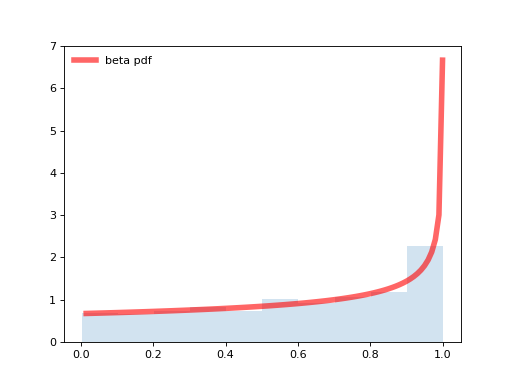

In [18]:
# Generates a 1000-element random sample from the beta distribution
# with parameters alpha = 1 and beta = 2/3

a = 1
b = 2/3

# Plots the beta distribution

beta_distribution_plot(a, b)

**2) A random sample of 1000 Californians is taken, 65% support the death penalty. What are your posterior mean and variance ? Plot the posterior density function.**

We denote $\theta$ the probability of a californian supporting the death penalty. And we assume the prior distribution:
$$\theta \sim Beta(1, \frac{2}{3})$$

Let denote by $y$ the random variable describing the number of californian supporting the death penalty in the observed population. We assume drawing from the population to be an independent operation. As such we consider a binomial distribution for y|$\theta$.
Thus the data likelihood is given by: 

$$p(y=k|\theta) = \binom{n}{k}\theta^{k}(1-\theta)^{n-k}$$With $n=1000$ and $k=650$.

We can give the posterior probability of $\theta$ (up to a constant) by using Bayes' such that:

\begin{align}
p(\theta|y) &\propto p(y|\theta)p(\theta) \\
& \propto \theta^{k+\alpha-1}(1-\theta)^{n-k+\beta-1} \\
\end{align}

This implies:

\begin{align}
\theta|y & \sim Beta(\alpha+k, n-k+\beta)
\end{align}

With $\alpha=1$, $\beta=\frac{2}{3}$, $n=1000$ and $k=650$. I.e.:

$$\theta|y \sim Beta(651, 350+\frac{2}{3})$$

In [19]:
new_a = a+650
new_b = b+1000-650

mean, var = beta.stats(new_a, new_b)

<IPython.core.display.Javascript object>


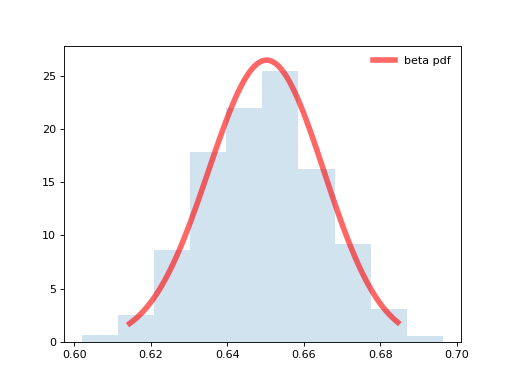

In [20]:
# Plots the beta distribution 

beta_distribution_plot(new_a, new_b)

**3) Examine the impact of the prior parameters on the posterior distribution through different statistics (i.e mean, median, 95% posterior interval).**

<u>Observations:</u>

Given the data displayed below, we see that increasing the values of the alpha and beta parameters of the prior distribution lead to an increase in the posterior distribution's mean and median (as well as the resulting 95% confidence interval). 

We see that increasing the value of $\alpha$ leads to increasing statistics (i.e. mean and median) while increasing the value of $\beta$ leads to decreases. However, we see that the impact of $\alpha$ is superior to that of $\beta$ when both are grown concurrently (below in steps of 5).

Since the Beta distribution is equivalent to the Uniform distribution when $\alpha$ and $\beta$ are set to 1, it means that, as we grow the values of the parameters of the prior distribution, we tend to bias the posterior distribution at an increasing rate.

<IPython.core.display.Javascript object>


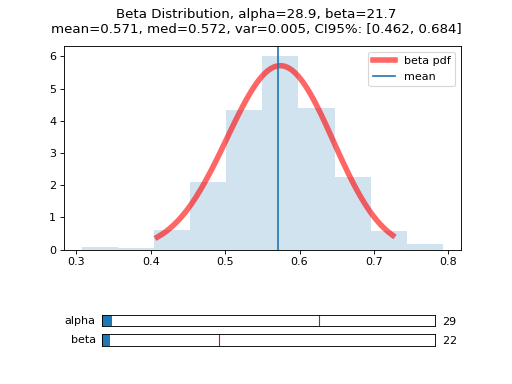

In [21]:
#/!\ It is import that the function returns fig, ax, and the slider objects,
#    here stored in variable f, otherwise the plot will be unresponsive outside 
#    the function's scope:
#    > https://github.com/matplotlib/matplotlib/issues/3105

f = beta_distribution_sliderplot(1., 2/3, 1000, 650)

In [22]:
results, heatmap_post_mean, heatmap_post_median = compute_priors_impact_on_posterior_beta_distribution(1000, 650)


In [23]:
results

,alpha,beta,post. alpha,post. beta,post. mean,post. median,95% post. CI
0,1,1,651,351,0.649701,0.649800,"[0.626, 0.676]"
1,1,5,651,355,0.647117,0.647215,"[0.621, 0.672]"
2,1,10,651,360,0.643917,0.644012,"[0.62, 0.67]"
3,1,15,651,365,0.640748,0.640840,"[0.615, 0.667]"
4,1,20,651,370,0.637610,0.637700,"[0.613, 0.663]"
...,...,...,...,...,...,...,...
116,50,30,700,380,0.648148,0.648240,"[0.624, 0.671]"
117,50,35,700,385,0.645161,0.645251,"[0.622, 0.668]"
118,50,40,700,390,0.642202,0.642289,"[0.617, 0.664]"
119,50,45,700,395,0.639269,0.639354,"[0.616, 0.663]"


In [24]:
heatmap_post_mean

In [25]:
heatmap_post_median

## Exercise 4

**1) Which of the expressions below correspond to the statement: *the probability of rain on Monday* ?**

- *Pr(rain)*
- **Pr(rain|Monday)** <-
- *Pr(Monday|rain)*
- **Pr(rain, Monday) / Pr(Monday)** <-


**2) Which of the following statements corresponds to the expression: *Pr(Monday|rain)* ?**

- *The probability of rain on Monday.*
- *The probability of rain, given that it is Monday.*
- **The probability that it is Monday, given that it is raining.** <-
- *The probability that it is Monday and it is raining.*


**3) Which of the expressions below correspond to the statement: *the probability that it is Monday, given that it is raining* ?**

- **Pr(Monday|rain)** <-
- *Pr(rain|Monday)*
- *Pr(rain | Monday)Pr(Monday)*
- **Pr(rain | Monday)Pr(Monday)/Pr(rain)** <-
- *Pr(Monday|rain)Pr(rain)/Pr(Monday)*

## Exercise 5

Suppose there are two species of panda bear. Both are equally common in the wild and live in the same places. They look exactly alike and eat the same food, and there is yet no genetic assay capable of telling them appart. They differ however in their family sizes. Species A gives birth to twins 10% of the time, otherwise birthing a single infant. Species B births twins 20% of the time, otherwise birthing singleton infants. Assume these numbers are known with certainty, from many years of field research. Now suppose you are managing a captive panda breeding program. You have a new female panda of unknown species, and she has just given birth to twins. 

**What is the probability that her next birth will also be twins ?**

We set the following:

- $P_A$, the event that a panda is of the species A
- $P_B$, the event that a panda is of the species B
- ${offspring}_{twin}$ or $O_t$, the event that a female panda gives birth to twins
- ${offspring}_{singleton}$ or $O_s$, the event that a female panda gives birth to a single offspring

By the information provided in the instructions, we have:

\begin{align}
\mathbb{P}(P_A) &= \frac{1}{2} \\
\mathbb{P}(P_B) &= \frac{1}{2} \\
\mathbb{P}(O_t|P_A) &= \frac{1}{10} \\
\mathbb{P}(O_s|P_A) &= \frac{1}{5} \\
\end{align}

We now denote:

- ${now}_{O_t}$, the event that a female panda gave birth to twins
- ${future}_{O_t}$, the event that the next litter of a female panda will be twins

As such, we set the probability that the next litter of a female panda will be twins, given that its current litter were twins as:

$$\mathbb{P}({future}_{O_t}|{now}_{O_t})$$

Based on this formulation of the problem we have:

\begin{align}
\mathbb{P}({future}_{O_t}|{now}_{O_t}) &= \frac{\mathbb{P}({future}_{O_t} \cap {now}_{O_t})}{\mathbb{P}({now}_{O_t})} \\
&= \frac{\mathbb{P}({future}_{O_t} \cap {now}_{O_t} \cap P_A) + \mathbb{P}({future}_{O_t} \cap {now}_{O_t} \cap P_B)}{\mathbb{P}({now}_{O_t} \cap P_A) + \mathbb{P}({now}_{O_t} \cap P_B)} \\
&= \frac{\mathbb{P}({future}_{O_t} \cap {now}_{O_t} | P_A)\mathbb{P}(P_A) + \mathbb{P}({future}_{O_t} \cap {now}_{O_t} | P_B)\mathbb{P}(P_B)}{\mathbb{P}({now}_{O_t} | P_A)\mathbb{P}(P_A) + \mathbb{P}({now}_{O_t} | P_B)\mathbb{P}(P_B)}, \text{ Marginal prob. rule}\\
&= \frac{\mathbb{P}({future}_{O_t}|P_A)\mathbb{P}({now}_{O_t}|P_A)\mathbb{P}(P_A) + \mathbb{P}({future}_{O_t}|P_B)\mathbb{P}({now}_{O_t} | P_B)\mathbb{P}(P_B)}{\mathbb{P}({now}_{O_t} | P_A)\mathbb{P}(P_A) + \mathbb{P}({now}_{O_t} | P_B)\mathbb{P}(P_B)}, \text{ births are independent}\\
&=\frac{(\frac{1}{10})^2*\frac{1}{2}+(\frac{1}{5})^2*\frac{1}{2}}{\frac{1}{10}*\frac{1}{2}+\frac{1}{5}*\frac{1}{2}} \\
&=\frac{(\frac{1}{10})^2+(\frac{1}{5})^2}{\frac{1}{10}+\frac{1}{5}} \\
&=\frac{1}{20}*\frac{10}{3}\\
\mathbb{P}({future}_{O_t}|{now}_{O_t})&=\frac{1}{6}
\end{align}

We conclude that the probability that the female panda's next birth will be twins is $\frac{1}{6}$.